In [140]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, pointbiserialr, f_oneway, spearmanr # Import spearmanr




# The dataset link: https://www.kaggle.com/datasets/globalmediadata/socialmediausage-sleepdata-sg

In [141]:
df = pd.read_csv('SocialMediaUsage_SleepLatencyAnalysis_Singapore.csv', encoding='utf-8')

# Knowing The Data

In [142]:
print(df.shape)

(500, 20)


In [143]:
df.head()

,Participant ID,Age,Gender,Chronotype,Average Daily Social Media Use Time (minutes),Dominant Social Media Platform,Frequency of Social Media Checking (number of times per day),Pre-Sleep Social Media Use Duration (minutes),Type of Social Media Content Consumed,Sleep Latency (minutes),Total Sleep Time (hours),Sleep Efficiency (%),Sleep Quality Rating,Wake After Sleep Onset (WASO) (minutes),Number of Awakenings (during sleep),Melatonin Level (pg/mL),Cortisol Level (pg/mL),Day of Week,Blue Light Exposure Before Sleep (minutes),Stress Level Rating
0,1,56,Other,Evening Owl,123.661212,Instagram,20,72.650150,Social Interaction,20.961023,4.953115,84.919279,3.369066,28.454612,3,27.475901,111.611989,Friday,47.683296,3.802238
1,2,46,Female,Neither,68.877915,Instagram,40,40.096685,News,19.012622,6.466231,84.647120,4.544391,18.160790,2,34.136387,123.477195,Friday,22.171777,2.768907
2,3,32,Male,Neither,143.799199,TikTok,29,58.147004,News,20.481638,5.204305,78.259513,1.506376,29.832344,3,17.813907,98.024130,Friday,29.615623,4.704535
3,4,60,Other,Evening Owl,213.318626,Twitter,5,51.842214,Social Interaction,29.892398,3.760281,74.195231,1.000000,37.331240,5,13.455934,131.011318,Thursday,46.778311,5.000000
4,5,25,Female,Evening Owl,183.767226,Twitter,39,81.919265,Entertainment,28.905470,5.186388,81.763091,1.186496,22.922240,4,16.317120,117.268808,Thursday,46.607758,5.000000


In [144]:
df.describe()

,Participant ID,Age,Average Daily Social Media Use Time (minutes),Frequency of Social Media Checking (number of times per day),Pre-Sleep Social Media Use Duration (minutes),Sleep Latency (minutes),Total Sleep Time (hours),Sleep Efficiency (%),Sleep Quality Rating,Wake After Sleep Onset (WASO) (minutes),Number of Awakenings (during sleep),Melatonin Level (pg/mL),Cortisol Level (pg/mL),Blue Light Exposure Before Sleep (minutes),Stress Level Rating
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,41.980000,138.511928,26.808000,68.774225,23.765558,5.240398,81.177902,2.341209,23.867780,3.222000,22.532367,113.505904,51.834984,3.647550
std,144.481833,13.800598,62.329189,12.824354,40.142413,7.954742,1.324331,6.576889,1.193130,8.191032,1.366914,12.770327,12.337649,33.103691,1.197424
min,1.000000,18.000000,31.037396,5.000000,6.692946,5.000000,3.000000,67.040582,1.000000,0.776081,0.000000,5.000000,84.260116,4.021635,1.000000
25%,125.750000,31.000000,80.657890,16.000000,36.980603,18.266476,4.136356,75.531255,1.068380,18.043526,2.000000,11.472222,104.861103,25.991967,2.710984
50%,250.500000,43.000000,143.028900,27.000000,61.264379,24.191395,5.190124,80.802759,2.146824,23.905560,3.000000,21.319072,113.105951,43.288773,3.848091
75%,375.250000,53.000000,192.593352,38.000000,94.261512,29.166518,6.402484,86.218339,3.293213,29.924286,4.000000,32.887053,122.626977,71.495318,4.903631
max,500.000000,65.000000,239.876882,49.000000,188.452528,43.925603,8.157458,96.365162,5.000000,45.271140,6.000000,58.141817,144.929444,179.519046,5.000000


In [145]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Participant ID                                                500 non-null    int64  
 1   Age                                                           500 non-null    int64  
 2   Gender                                                        500 non-null    object 
 3   Chronotype                                                    500 non-null    object 
 4   Average Daily Social Media Use Time (minutes)                 500 non-null    float64
 5   Dominant Social Media Platform                                500 non-null    object 
 6   Frequency of Social Media Checking (number of times per day)  500 non-null    int64  
 7   Pre-Sleep Social Media Use Duration (minutes)                 500 non-n

In [146]:
df.columns

Index(['Participant ID', 'Age', 'Gender', 'Chronotype',
       'Average Daily Social Media Use Time (minutes)',
       'Dominant Social Media Platform',
       'Frequency of Social Media Checking (number of times per day)',
       'Pre-Sleep Social Media Use Duration (minutes)',
       'Type of Social Media Content Consumed', 'Sleep Latency (minutes)',
       'Total Sleep Time (hours)', 'Sleep Efficiency (%)',
       'Sleep Quality Rating', 'Wake After Sleep Onset (WASO) (minutes)',
       'Number of Awakenings (during sleep)', 'Melatonin Level (pg/mL)',
       'Cortisol Level (pg/mL)', 'Day of Week',
       'Blue Light Exposure Before Sleep (minutes)', 'Stress Level Rating'],
      dtype='object')

*We need to select the features that we will deal with*

# Feature selection & pre‑processing


Correlation of Features with Sleep Efficiency (%) (Sorted by Absolute Value):
                                                    Correlation
Average Daily Social Media Use Time (minutes)           -0.9554
Sleep Quality Rating                                     0.8948
Total Sleep Time (hours)                                 0.8942
Stress Level Rating                                     -0.8854
Melatonin Level (pg/mL)                                  0.8800
Number of Awakenings (during sleep)                     -0.8641
Wake After Sleep Onset (WASO) (minutes)                 -0.7752
Sleep Latency (minutes)                                 -0.7657
Pre-Sleep Social Media Use Duration (minutes)           -0.7171
Blue Light Exposure Before Sleep (minutes)              -0.6516
Cortisol Level (pg/mL)                                  -0.5120
Dominant Social Media Platform                          -0.0580
Frequency of Social Media Checking (number of t...      -0.0560
Type of Social Media Cont

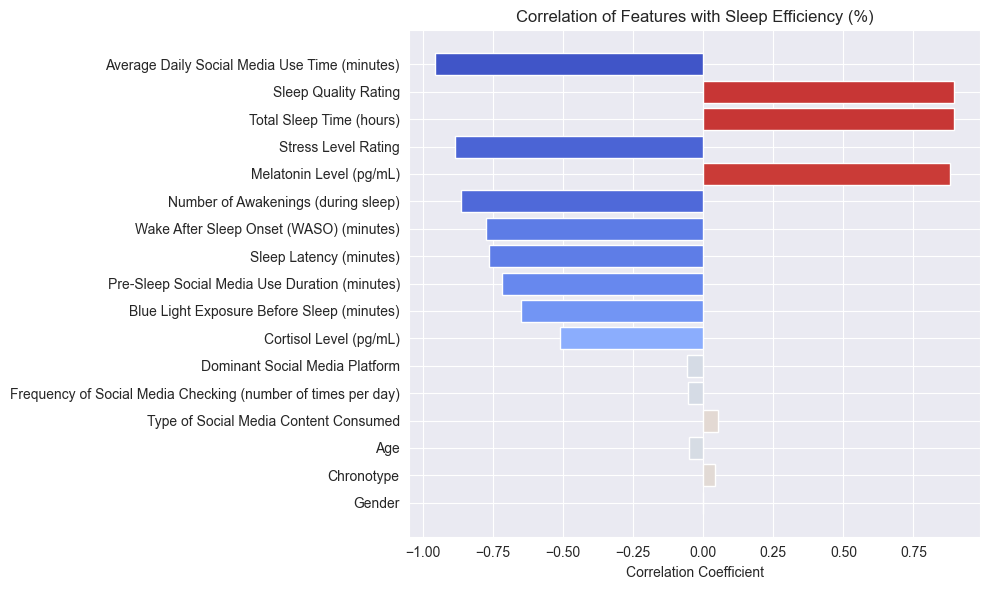

In [147]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, pointbiserialr, f_oneway, spearmanr

# Identify the target variable
target_variable = 'Sleep Efficiency (%)'  # Changed target variable

# Identify numerical and categorical columns
all_cols = df.columns.tolist()
all_cols.remove('Participant ID')  # Assuming Participant ID is not a feature

numerical_cols = [col for col in [
    'Age', 'Average Daily Social Media Use Time (minutes)',
    'Frequency of Social Media Checking (number of times per day)',
    'Pre-Sleep Social Media Use Duration (minutes)',
    'Blue Light Exposure Before Sleep (minutes)',
    'Total Sleep Time (hours)', 'Sleep Latency (minutes)',
    # 'Sleep Efficiency (%)', # Target variable, removed from features
    'Number of Awakenings (during sleep)',
    'Wake After Sleep Onset (WASO) (minutes)',
    'Sleep Quality Rating', 'Stress Level Rating',  # Added Stress Level Rating as a feature
    'Melatonin Level (pg/mL)', 'Cortisol Level (pg/mL)'
] if col != target_variable and col in all_cols]  # Ensure column exists and is not the target

categorical_cols = [col for col in ['Gender', 'Chronotype', 'Dominant Social Media Platform',
                                   'Type of Social Media Content Consumed'] if col in all_cols]  # Ensure column exists

# Initialize a dictionary to store correlation results
correlations = {}

# Compute Pearson correlations for numerical features
for col in numerical_cols:
    valid_data = df[[col, target_variable]].dropna()
    if len(valid_data) > 1:
        corr, _ = pearsonr(valid_data[col], valid_data[target_variable])
        correlations[col] = corr
    else:
        correlations[col] = 0.0

# Compute correlations for categorical features
for col in categorical_cols:
    valid_data = df[[col, target_variable]].dropna()
    if len(valid_data) < 2:
        correlations[col] = 0.0
        continue

    if col == 'Gender':  # Binary categorical (point-biserial correlation)
        if set(valid_data[col].unique()) == {'Male', 'Female'}:
            valid_data['Gender_binary'] = valid_data[col].map({'Male': 0, 'Female': 1})
        elif 'Male' in valid_data[col].unique():
            valid_data['Gender_binary'] = valid_data[col].map({'Male': 0})
        elif 'Female' in valid_data[col].unique():
            valid_data['Gender_binary'] = valid_data[col].map({'Female': 1})
        else:
            valid_data['Gender_binary'] = np.nan

        if valid_data['Gender_binary'].nunique() > 1 and len(valid_data.dropna(subset=['Gender_binary'])) > 1:
            corr, _ = pointbiserialr(valid_data['Gender_binary'].dropna(), valid_data[target_variable].dropna())
            correlations[col] = corr
        else:
            correlations[col] = 0.0
    else:
        if valid_data[col].nunique() < 2:
            correlations[col] = 0.0
            continue

        groups = [valid_data[valid_data[col] == category][target_variable] for category in valid_data[col].unique()]
        groups = [g for g in groups if len(g) > 0]

        if len(groups) > 1:
            try:
                f_stat, _ = f_oneway(*groups)
                eta_squared = f_stat / (f_stat + len(valid_data) - len(groups))
                if eta_squared < 0:
                    eta_squared = 0

                group_means = valid_data.groupby(col)[target_variable].mean().sort_index()
                category_numerical_labels = pd.Series(np.arange(len(group_means)), index=group_means.index)

                if len(group_means) > 1 and category_numerical_labels.nunique() > 1:
                    aligned_means, aligned_labels = group_means.align(category_numerical_labels, join='inner')
                    if len(aligned_means) > 1:
                        corr_direction, _ = spearmanr(aligned_labels, aligned_means)
                        correlations[col] = np.sign(corr_direction) * np.sqrt(eta_squared)
                    else:
                        correlations[col] = 0.0
                else:
                    correlations[col] = 0.0

            except ValueError:
                correlations[col] = 0.0
            except Exception as e:
                print(f"An error occurred calculating correlation for {col}: {e}")
                correlations[col] = 0.0
        else:
            correlations[col] = 0.0

# Convert correlations to DataFrame and sort
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
corr_df['Absolute Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Absolute Correlation'])
corr_df = corr_df.sort_values(by='Absolute Correlation', ascending=False)

print(f"\nCorrelation of Features with {target_variable} (Sorted by Absolute Value):")
if 'Correlation' in corr_df.columns:
    print(corr_df[['Correlation']].round(4))
else:
    print(f"No valid correlations were calculated for {target_variable}.")

# Plot with matplotlib barh and coolwarm colormap
if not corr_df.empty:
    plt.figure(figsize=(10, 6))
    norm = plt.Normalize(-1, 1)
    colors = plt.cm.coolwarm(norm(corr_df['Correlation']))
    plt.barh(corr_df.index, corr_df['Correlation'], color=colors)
    plt.title(f'Correlation of Features with {target_variable}')
    plt.xlabel('Correlation Coefficient')
    plt.gca().invert_yaxis()  # Highest correlation on top
    plt.tight_layout()
    plt.show()
else:
    print(f"No data to plot correlations for {target_variable}.")


*Our target is Sleep Efficiency (%)
and the features we selected are:
    'Average Daily Social Media Use Time (minutes)',
    'Frequency of Social Media Checking (number of times per day)',
    'Pre-Sleep Social Media Use Duration (minutes)',
    'Dominant Social Media Platform',
    'Type of Social Media Content Consumed',
	'Blue Light Exposure Before Sleep (minutes)'*

In [148]:
selected_cols = [
    'Average Daily Social Media Use Time (minutes)',
    'Frequency of Social Media Checking (number of times per day)',
    'Pre-Sleep Social Media Use Duration (minutes)',
    'Dominant Social Media Platform',
    'Type of Social Media Content Consumed',
	'Blue Light Exposure Before Sleep (minutes)'
]
target_col = 'Sleep Efficiency (%)'

In [149]:
print(df.isnull().sum())

Participant ID                                                  0
Age                                                             0
Gender                                                          0
Chronotype                                                      0
Average Daily Social Media Use Time (minutes)                   0
Dominant Social Media Platform                                  0
Frequency of Social Media Checking (number of times per day)    0
Pre-Sleep Social Media Use Duration (minutes)                   0
Type of Social Media Content Consumed                           0
Sleep Latency (minutes)                                         0
Total Sleep Time (hours)                                        0
Sleep Efficiency (%)                                            0
Sleep Quality Rating                                            0
Wake After Sleep Onset (WASO) (minutes)                         0
Number of Awakenings (during sleep)                             0
Melatonin 

In [150]:
# count of the values
df['Dominant Social Media Platform'].value_counts()

Dominant Social Media Platform
Twitter      111
TikTok       110
Instagram    106
Facebook      89
Snapchat      84
Name: count, dtype: int64

In [151]:
# count of the values
df['Type of Social Media Content Consumed'].value_counts()

Type of Social Media Content Consumed
News                  176
Social Interaction    165
Entertainment         159
Name: count, dtype: int64

*No null data found*

In [152]:
for column in df[selected_cols + [target_col]].select_dtypes(include=['number']).columns:
    fig = px.box(df, x=column, title=f'Box plot for {column}')
    fig.show()


*There is almost no outliers*

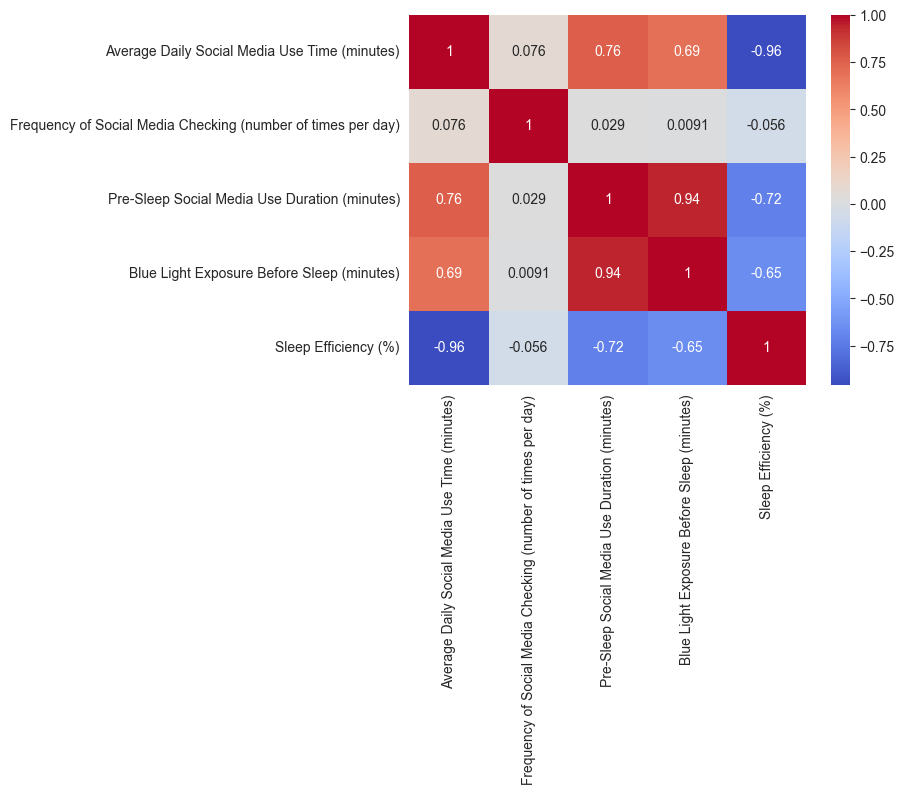

In [153]:
df_numeric = df[selected_cols + [target_col]].select_dtypes(include=[np.number])
sns.heatmap(df_numeric.corr(), cmap='coolwarm', annot=True)
plt.show()

In [154]:
X = pd.get_dummies(df[selected_cols])
y = df[target_col]

num_cols = [
    "Average Daily Social Media Use Time (minutes)",
    "Frequency of Social Media Checking (number of times per day)",
    "Pre-Sleep Social Media Use Duration (minutes)",
	'Blue Light Exposure Before Sleep (minutes)'
]
# Ensure float dtype so scaling writes back safely
X[num_cols] = X[num_cols].astype(float)


In [155]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [156]:
x_scaler = StandardScaler()
X_train.loc[:, num_cols] = x_scaler.fit_transform(X_train[num_cols])
X_test.loc[:,  num_cols] = x_scaler.transform(X_test[num_cols])
y_scaler = StandardScaler()
# Reshape y_train to 2D and fit_transform
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [157]:
X_train.head()

,Average Daily Social Media Use Time (minutes),Frequency of Social Media Checking (number of times per day),Pre-Sleep Social Media Use Duration (minutes),Blue Light Exposure Before Sleep (minutes),Dominant Social Media Platform_Facebook,Dominant Social Media Platform_Instagram,Dominant Social Media Platform_Snapchat,Dominant Social Media Platform_TikTok,Dominant Social Media Platform_Twitter,Type of Social Media Content Consumed_Entertainment,Type of Social Media Content Consumed_News,Type of Social Media Content Consumed_Social Interaction
249,1.321221,-0.460583,1.068586,0.223077,False,True,False,False,False,False,False,True
433,-0.107172,-1.558610,0.258143,-0.263488,True,False,False,False,False,False,True,False
19,1.303500,0.323722,-0.480501,-0.445730,False,False,False,False,True,False,True,False
322,-1.195995,0.715874,-0.548167,-0.601694,False,False,False,False,True,True,False,False
332,0.654487,0.872735,1.209560,0.239143,False,False,True,False,False,False,True,False


# Helper function for model evaluation

In [158]:
def evaluate(y_true, y_pred, name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{name:<15s}  MAE: {mae:.3f}   RMSE: {rmse:.3f}   R²: {r2:.3f}')
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Model 1: Linear Regression

In [159]:
lin = LinearRegression()
lin.fit(X_train, y_train_scaled)

# Predict on X_test (unscaled features if you scaled them properly)
y_pred_scaled = lin.predict(X_test)

# Inverse transform predictions back to original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Now evaluate using original y_test and unscaled predictions
lin_metrics = evaluate(y_test, y_pred, 'Linear Regression')


Linear Regression  MAE: 1.795   RMSE: 2.211   R²: 0.874


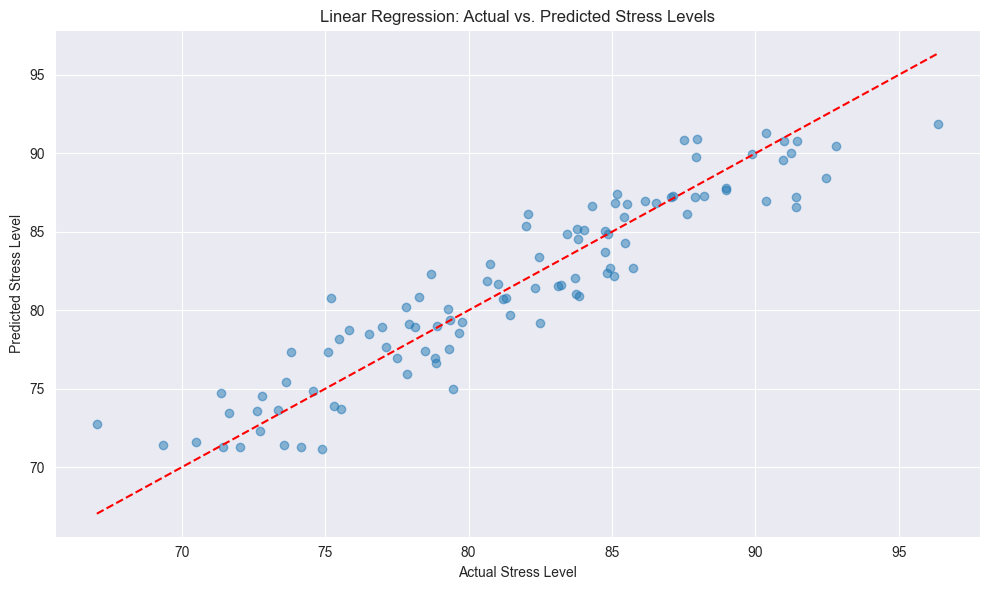

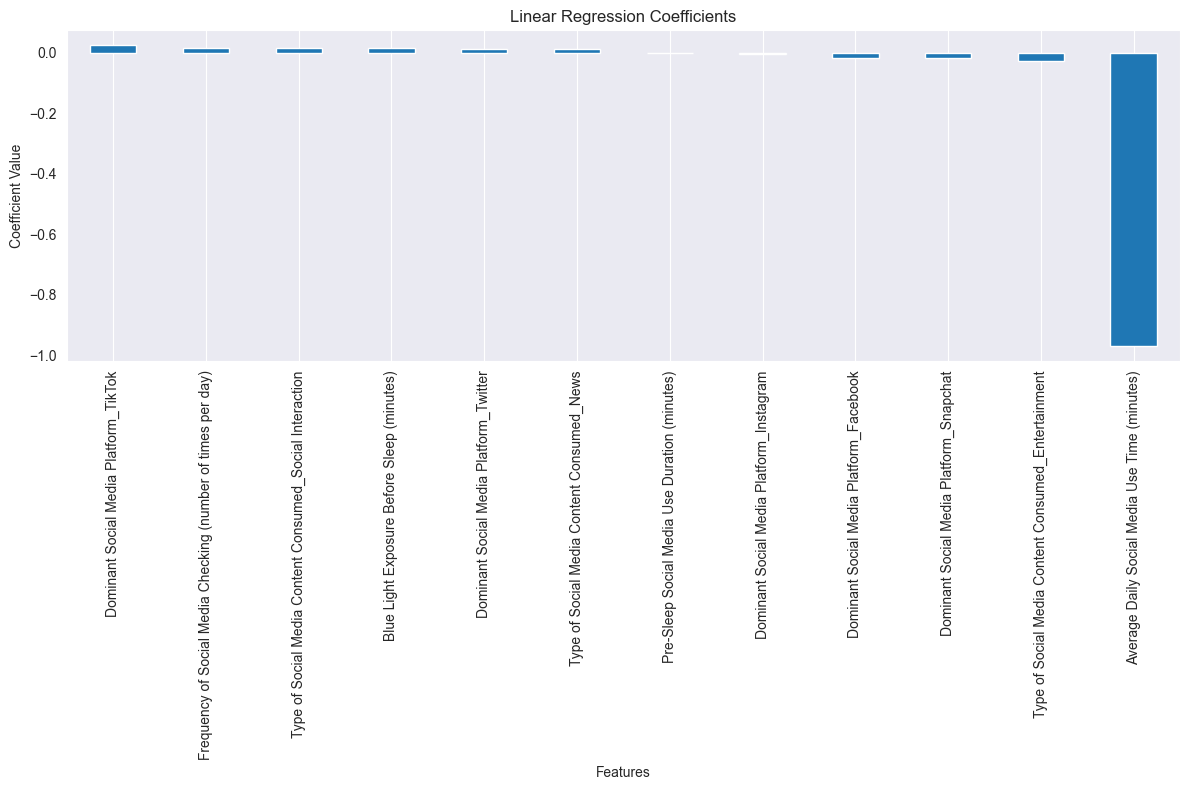

In [160]:
# Visualize Linear Regression predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Stress Level')
plt.ylabel('Predicted Stress Level')
plt.title('Linear Regression: Actual vs. Predicted Stress Levels')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the coefficients
coef = pd.Series(lin.coef_.ravel(), index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
coef.plot(kind='bar')
plt.title('Linear Regression Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Model 2: Ridge Regression

In [161]:
ridge = RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5)  # searches for the best α on a grid
ridge.fit(X_train, y_train_scaled)
# Predict on X_test
y_pred_ridge_scaled = ridge.predict(X_test)

# Inverse transform predictions back to original scale
y_pred_ridge = y_scaler.inverse_transform(y_pred_ridge_scaled.reshape(-1, 1)).flatten()

# Evaluate with original y_test and unscaled predictions
ridge_metrics = evaluate(y_test, y_pred_ridge, 'Ridge Regression')

Ridge Regression  MAE: 1.797   RMSE: 2.216   R²: 0.873


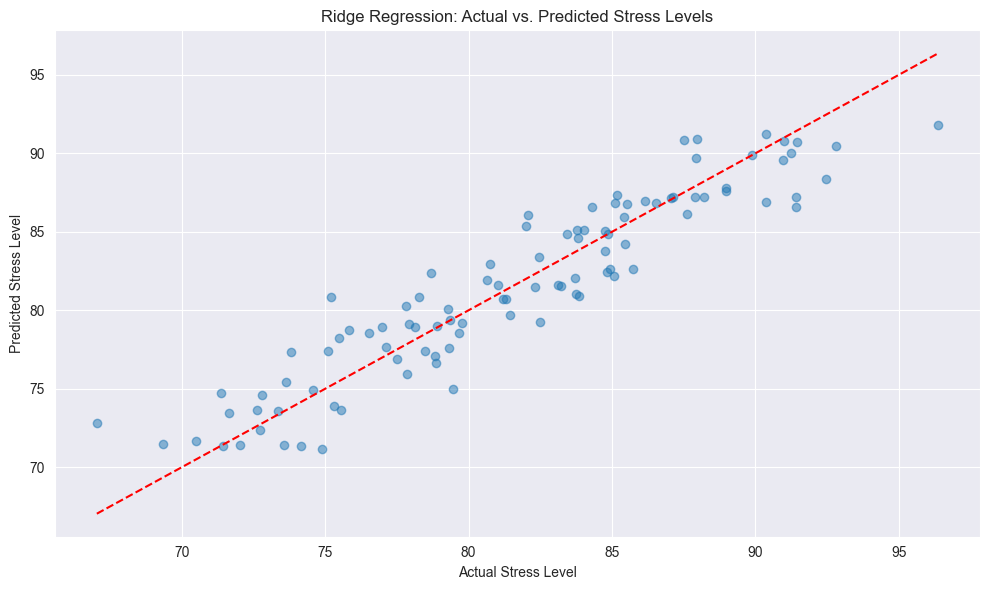

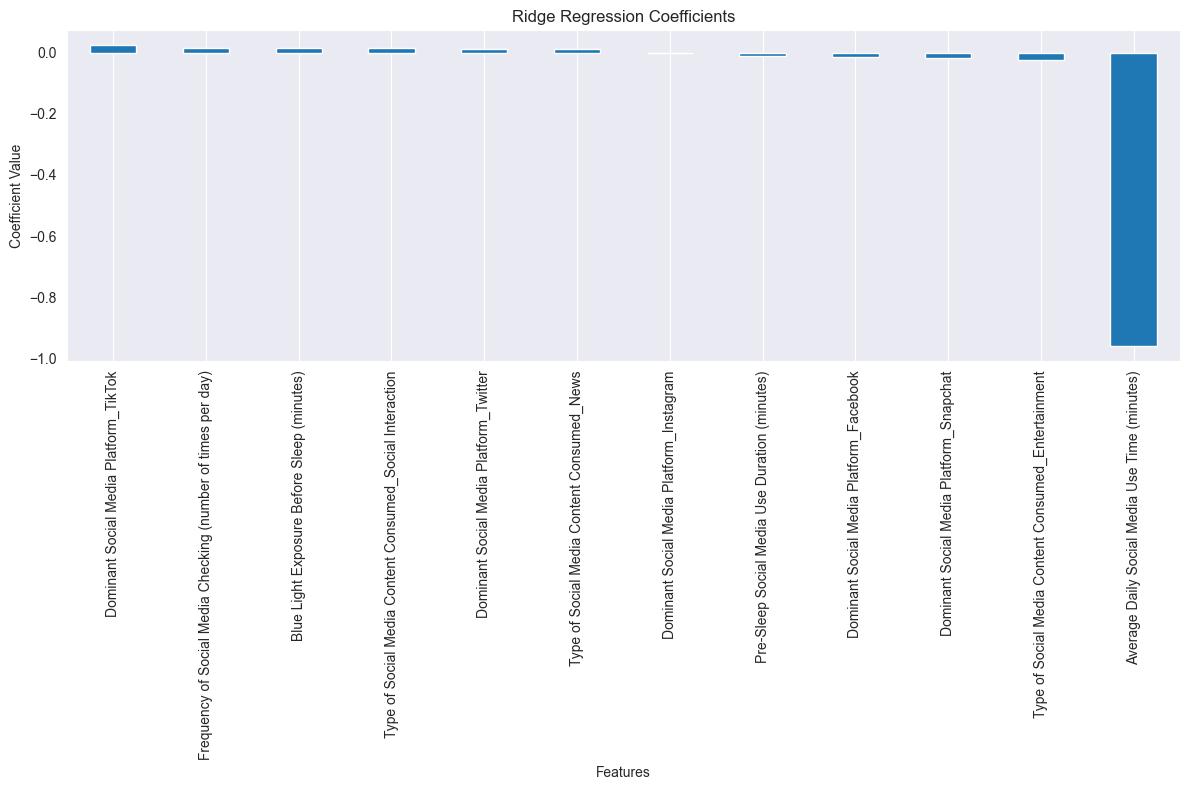

In [162]:
import matplotlib.pyplot as plt
import pandas as pd

# Visualize Ridge Regression predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Stress Level')
plt.ylabel('Predicted Stress Level')
plt.title('Ridge Regression: Actual vs. Predicted Stress Levels')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the coefficients
ridge_coef = pd.Series(ridge.coef_.ravel(), index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
ridge_coef.plot(kind='bar')
plt.title('Ridge Regression Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Model 3: Random Forest

In [163]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train_scaled.ravel())  # Ensure y is 1D

# Predict on test set (scaled target space)
y_pred_rf_scaled = rf.predict(X_test)

# Inverse transform predictions back to original scale
y_pred_rf = y_scaler.inverse_transform(y_pred_rf_scaled.reshape(-1, 1)).flatten()

# Evaluate with original y_test and unscaled predictions
rf_metrics = evaluate(y_test, y_pred_rf, 'Random Forest')


Random Forest    MAE: 2.065   RMSE: 2.495   R²: 0.839


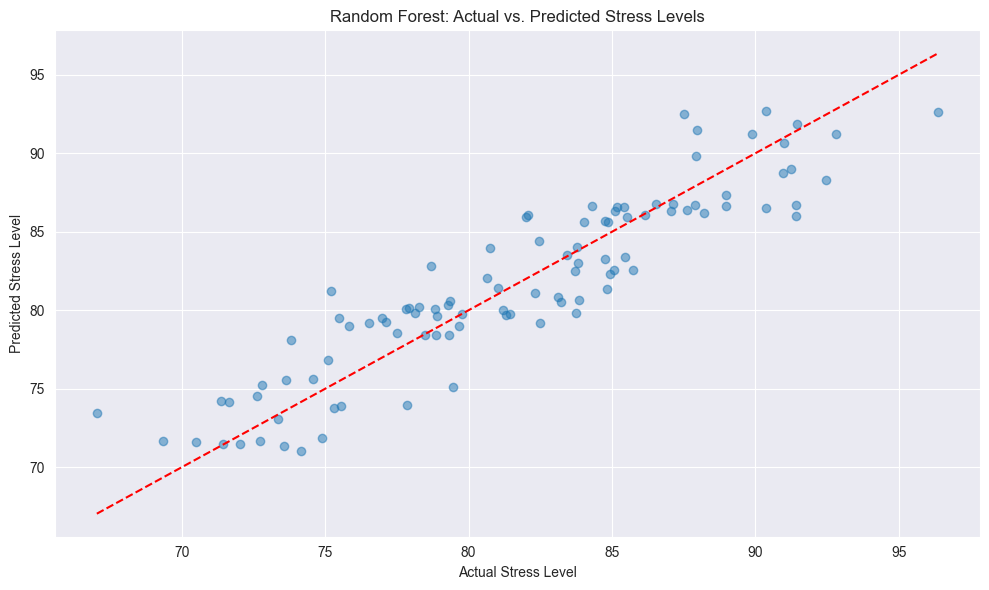

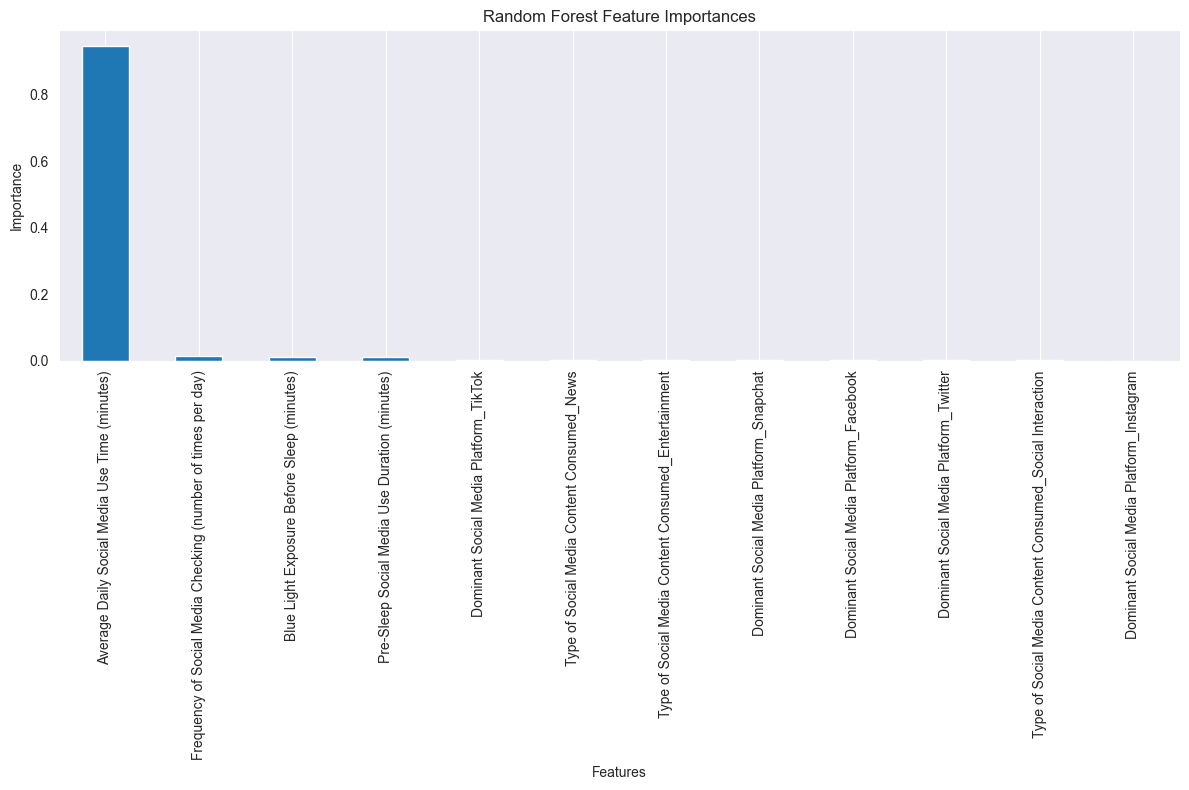

In [164]:
import matplotlib.pyplot as plt
import pandas as pd

# Visualize Random Forest predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Stress Level')
plt.ylabel('Predicted Stress Level')
plt.title('Random Forest: Actual vs. Predicted Stress Levels')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize feature importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feat_imp.plot(kind='bar')
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Model 3: polynomial regression

In [165]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

poly_degrees = [1, 2, 3, 4, 5, 6]

results = []

for degree in poly_degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)

    model = LinearRegression()
    model.fit(X_poly_train, y_train_scaled)

    X_poly_test = poly.transform(X_test)  # Note: use transform, NOT fit_transform on test

    y_pred_scaled = model.predict(X_poly_test)

    # Inverse transform predictions back to original scale
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({'Degree': degree, 'MSE': mse, 'R2': r2})

metrics_df = pd.DataFrame(results)

print(metrics_df)


   Degree           MSE           R2
0       1      4.889384     0.873590
1       2      5.746236     0.851437
2       3      9.826632     0.745943
3       4  88746.991085 -2293.461224
4       5    192.168834    -3.968325
5       6    257.507205    -5.657581


*polynomial regression is not the best solution because this indicates typical behavior related to overfitting and numerical instability in polynomial regression as the degree increases.*

# Model Comparison

In [166]:
# Create a dataframe to compare models
models = ['Linear Regression', 'Ridge Regression', 'Random Forest']
metrics = ['MAE', 'RMSE', 'R2']
comparison = pd.DataFrame(index=models, columns=metrics)
comparison.loc['Linear Regression'] = pd.Series(lin_metrics)
comparison.loc['Ridge Regression'] = pd.Series(ridge_metrics)
comparison.loc['Random Forest'] = pd.Series(rf_metrics)
comparison

,MAE,RMSE,R2
Linear Regression,1.795131,2.211195,0.87359
Ridge Regression,1.796645,2.215762,0.873067
Random Forest,2.064776,2.494841,0.839079


C:\Users\tarok\AppData\Local\Temp\ipykernel_12932\1630134311.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\tarok\AppData\Local\Temp\ipykernel_12932\1630134311.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\tarok\AppData\Local\Temp\ipykernel_12932\1630134311.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



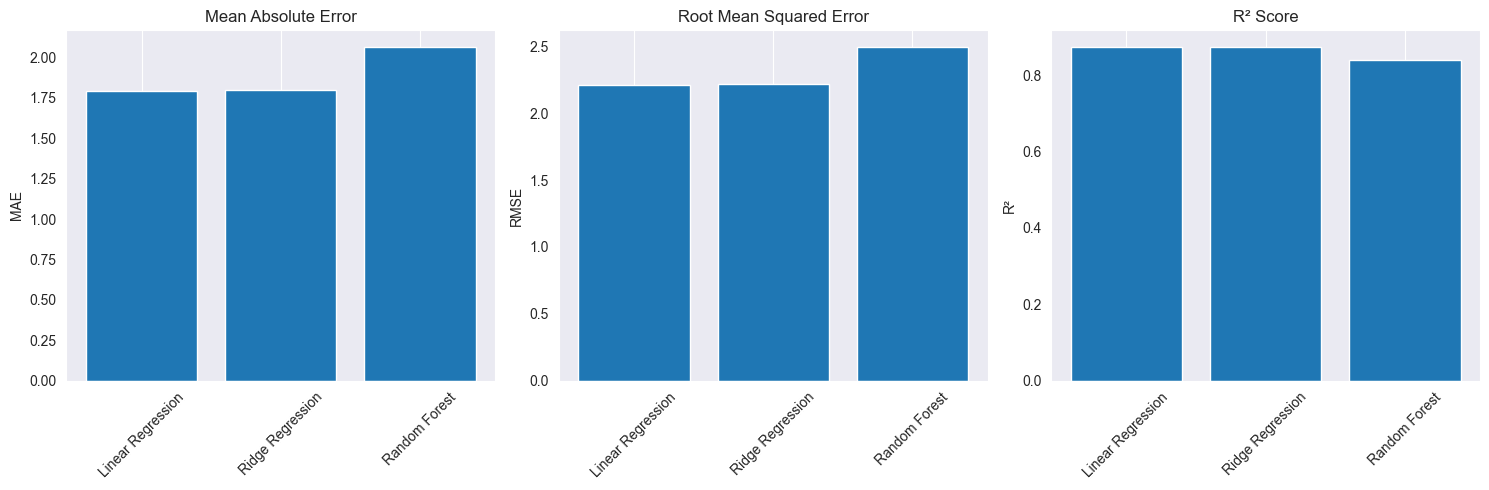

In [167]:
# Visualize model comparison
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# MAE comparison
axs[0].bar(models, comparison['MAE'])
axs[0].set_title('Mean Absolute Error')
axs[0].set_ylabel('MAE')
axs[0].set_xticklabels(models, rotation=45)
axs[0].grid(axis='y')

# RMSE comparison
axs[1].bar(models, comparison['RMSE'])
axs[1].set_title('Root Mean Squared Error')
axs[1].set_ylabel('RMSE')
axs[1].set_xticklabels(models, rotation=45)
axs[1].grid(axis='y')

# R2 comparison
axs[2].bar(models, comparison['R2'])
axs[2].set_title('R² Score')
axs[2].set_ylabel('R²')
axs[2].set_xticklabels(models, rotation=45)
axs[2].grid(axis='y')

plt.tight_layout()
plt.show()

### So we will choose the linear regression model

In [168]:
import joblib

# Save model
joblib.dump(lin, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [169]:
# Save scalers
joblib.dump(x_scaler, 'regression_x_scaler.pkl')
joblib.dump(y_scaler, 'regression_y_scaler.pkl')

['regression_y_scaler.pkl']